## Import Packages

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# utility functions
from utils import get_device, plot_learning_curve, plot_pred

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-h5bkf8xb because the default path (/home/ckwu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Dataset Class
1. Read dataset files
2. Extract features
3. Convert to train/dev/test sets
4. Normalize features

In [169]:
class COVID19Dataset(Dataset):
    def __init__(self,
                 path, # dataset file
                 mode="train", # train/dev/test
                 target_only=False): # whether use the target features
        self.mode = mode

        # read the data
        with open(path, "r") as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # set the feature columns
        if not target_only:
            feature_cols = list(range(93))
        else:
            feature_cols = list(range(40)) + [57, 75]

        # convert to tensors (test/dev/test ready format)
        if mode == "test":
            data = data[:, feature_cols] # extract features
            self.data = torch.FloatTensor(data) # for other functions (e.g. __getitem__) to use
        else:
            target = data[:, -1] # labels
            data = data[:, feature_cols] # cannot execute this line first, or else the target is incorrect
            
            # 9/1 split
            if mode == "train":
                indices = [i for i in range(len(data)) if i % 3 != 0]
            elif mode == "dev":
                indices = [i for i in range(len(data)) if i % 3 == 0]
            else:
                raise ValueError("The argument 'mode' must be either train/dev/test.")
            
            self.data = torch.FloatTensor(data[indices]) #, dtype=torch.float)
            self.target = torch.FloatTensor(target[indices]) #, dtype=torch.float)

        # normalize features (do not need to normalize the first 40 one-hot features)
        # self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) / self.data[:, 40:].std(dim=0, keepdim=True)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)        

        # print success message
        self.dim = self.data.shape[1]
        print(f"Finish loading the {self.mode} set of COVID19 Dataset. ({len(self.data)} samples found, each with {self.dim} dim)")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.mode == "test":
            return self.data[idx]
        else:
            return self.data[idx], self.target[idx]

## DataLoader

In [170]:
def get_dataloader(path, mode, target_only=False, batch_size=32, n_jobs=0):
    dataset = COVID19Dataset(path, mode, target_only)
    shuffle = mode == "train"
    return DataLoader(dataset, batch_size, shuffle, num_workers=n_jobs, pin_memory=True, drop_last=False)

## Build the DNN Model

In [186]:
class RegressionDNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionDNN, self).__init__()

        # try different model structure
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

        self.criterion = nn.MSELoss(reduction="mean")
    
    def forward(self, x):
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

## Train/Dev/Test Functions

In [187]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [188]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [189]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

## Hyper-Parameters

In [191]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                    # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 64,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        # 'momentum': 0.9            # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/two_layers_2.pth'  # your model will be saved here
}

## Load Data and Model

In [192]:
tr_path = "./data/covid_train.csv"
tt_path = "./data/covid_test.csv"

tr_set = get_dataloader(tr_path, mode='train', batch_size=config['batch_size'], target_only=target_only)
dv_set = get_dataloader(tr_path, mode='dev', batch_size=config['batch_size'], target_only=target_only)
tt_set = get_dataloader(tt_path, mode='test', batch_size=config['batch_size'], target_only=target_only)

model = RegressionDNN(tr_set.dataset.dim).to(device)

Finish loading the train set of COVID19 Dataset. (1800 samples found, each with 42 dim)
Finish loading the dev set of COVID19 Dataset. (900 samples found, each with 42 dim)
Finish loading the test set of COVID19 Dataset. (893 samples found, each with 42 dim)


## Start Training

In [193]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 261.5354)
Saving model (epoch =    2, loss = 113.7167)
Saving model (epoch =    3, loss = 19.0285)
Saving model (epoch =    4, loss = 6.5163)
Saving model (epoch =    5, loss = 3.8883)
Saving model (epoch =    6, loss = 3.0997)
Saving model (epoch =    7, loss = 2.7567)
Saving model (epoch =    8, loss = 2.5262)
Saving model (epoch =    9, loss = 2.3424)
Saving model (epoch =   10, loss = 2.2068)
Saving model (epoch =   11, loss = 2.0977)
Saving model (epoch =   12, loss = 2.0127)
Saving model (epoch =   13, loss = 1.9389)
Saving model (epoch =   14, loss = 1.8780)
Saving model (epoch =   15, loss = 1.8262)
Saving model (epoch =   16, loss = 1.7840)
Saving model (epoch =   17, loss = 1.7448)
Saving model (epoch =   18, loss = 1.7187)
Saving model (epoch =   19, loss = 1.6863)
Saving model (epoch =   20, loss = 1.6618)
Saving model (epoch =   21, loss = 1.6326)
Saving model (epoch =   22, loss = 1.6142)
Saving model (epoch =   23, loss = 1.5894)
Saving

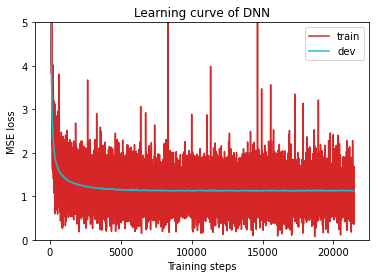

In [194]:
plot_learning_curve(model_loss_record, title="DNN")

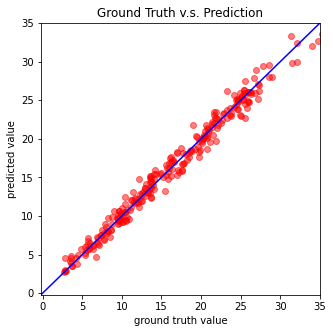

In [168]:
del model
model = RegressionDNN(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [163]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, './preds/two_layers.csv')         # save prediction file to pred.csv

Saving results to ./preds/two_layers.csv
